In [1]:
import pandas as pd
import os
import soundfile as sf
import argparse
import librosa
import numpy as np
import scipy as sp
import scipy.signal
import scipy.stats
import webrtcvad
import collections
import contextlib
import struct
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import time

In [2]:
def float2pcm(sig, dtype='int16'):
    sig = np.asarray(sig)
    if sig.dtype.kind != 'f':
        raise TypeError("'sig' must be a float array")
    dtype = np.dtype(dtype)
    if dtype.kind not in 'iu':
        raise TypeError("'dtype' must be an integer type")

    i = np.iinfo(dtype)
    abs_max = 2 ** (i.bits - 1)
    offset = i.min + abs_max
    return (sig * abs_max + offset).clip(i.min, i.max).astype(dtype)


def run_vad(data, aggress=2, window_duration=0.03, samplerate=16000):
    vad = webrtcvad.Vad()
    vad.set_mode(aggress)
    audio = float2pcm(data)
    raw_samples = struct.pack("%dh" % len(audio), *audio)
    samples_per_window = int(window_duration * samplerate)
    number_windows = int(np.floor(len(audio) / samples_per_window))
    bytes_per_sample = 2

    segments = []
    for i in np.arange(number_windows):
        raw_frame = raw_samples[i * bytes_per_sample * samples_per_window:
                                (i + 1) * bytes_per_sample * samples_per_window]
        is_speech = vad.is_speech(raw_frame, sample_rate=samplerate)
        segments.append(dict(
            start=i * samples_per_window,
            stop=(i + 1) * samples_per_window - 1,
            is_speech=is_speech))

    old_bool = segments[0]['is_speech']
    new_start = segments[0]['start']

    long_segments = []
    for i, segment in enumerate(segments):
        new_bool = segment['is_speech']
        if old_bool == new_bool:
            new_stop = segment['stop']
        else:
            long_segments.append(dict(
                start=new_start,
                stop=new_stop,
                is_speech=old_bool))
            new_start = segment['start']
            new_stop = segment['stop']
        old_bool = new_bool
        if i == len(segments) - 1:
            long_segments.append(dict(
                start=new_start,
                stop=new_stop,
                is_speech=old_bool))
    return long_segments

In [396]:
def compute_lpc(audio, len_lpc, window_length_sec=0.025, samplerate=16000):
    len_lpc = int(len_lpc)
    window_length = int(window_length_sec * samplerate)
    win_number = int(np.floor(len(audio) / window_length))

    coeff = np.zeros((win_number, len_lpc + 1))
    frames = np.zeros((win_number, window_length - 2 * len_lpc - 2))
    res = np.zeros((win_number, window_length - 2 * len_lpc - 2))
    count = 0
    for i in np.arange(win_number):
        frame = audio[i * window_length:(i + 1) * window_length]

        try:
            a = librosa.lpc(frame, len_lpc)
        except:
            count = count + 1
            coeff[i, :] = np.nan
            res[i, :] = np.nan
            frames[i, :] = np.nan
            continue

        coeff[i, :] = a
        frames[i, :] = frame[len_lpc + 1:-len_lpc - 1]
        res_frame = np.asarray(scipy.signal.lfilter(a, [1], frame))
        res[i, :] = res_frame[len_lpc + 1:-len_lpc - 1]

    if count != 0:
        print('In this audio {} not valid frames of 0.025 sec were found'.format(count))
    #res = res[~np.isnan(res).any(axis=1)]
    #coeff = coeff[~np.isnan(coeff).any(axis=1)]
    # here I want to remove the samples where res is not valid (for computing gain I need them to be synchronized)
    #frames = frames[~np.isnan(frames).any(axis=1)]

    return res, coeff, frames


def compute_ltp(err, samplerate=16000, analysis_frame_length_sec=0.005):
    analysis_frame_length = int(np.round(analysis_frame_length_sec * samplerate))
    win_number = int(np.floor(len(err) / analysis_frame_length))
    p_min = int(np.round(0.00625 * samplerate))
    p_max = int(np.round(0.025 * samplerate))

    J_min = np.ones((win_number,)) * 10e9
    M_opt = np.zeros((win_number,))
    b_opt = np.zeros((win_number,))
    best_res = []
    lpc_err = []

    count = 0
    for i in np.arange(win_number):

        current_start_index = int(i * analysis_frame_length)  # bs

        if current_start_index < p_max:
            # best_res.append(np.zeros((analysis_frame_length,)))
            continue

        if np.any(np.isnan(err[current_start_index - p_max : current_start_index + analysis_frame_length])):
            count = count + 1
            continue
        gains = []
        for m in np.arange(p_max, p_min + 1, -1):
            b_num = np.sum(err[current_start_index: current_start_index + analysis_frame_length] *
                           err[current_start_index - m: current_start_index - m + analysis_frame_length])
            b_den = np.sum(err[current_start_index - m: current_start_index - m + analysis_frame_length] ** 2)
    
            b = b_num / b_den
            J_1 = err[current_start_index: current_start_index + analysis_frame_length]
            J_2 = b * err[current_start_index - m: current_start_index - m + analysis_frame_length]

            J = np.sum((J_1 - J_2) ** 2)
            gains.append(err[current_start_index - m: current_start_index - m + analysis_frame_length])

            if J < J_min[i]:
                J_min[i] = J
                M_opt[i] = m
                best_J_1 = J_1
                best_J_2 = J_2
        #print(gains)
        best_res.append(best_J_1 - best_J_2)
        lpc_err.append(err[current_start_index: current_start_index + analysis_frame_length])

    print('In this audio {} not valid frames of 0.005 sec were found'.format(count))
    return np.asarray(best_res), np.asarray(lpc_err)



In [395]:
def compute_ltp_fast(err, samplerate=16000, analysis_frame_length_sec=0.005):
    analysis_frame_length = int(np.round(analysis_frame_length_sec * samplerate))
    win_number = int(np.floor(len(err) / analysis_frame_length))
    p_min = int(np.round(0.00625 * samplerate))
    p_max = int(np.round(0.025 * samplerate))

    best_res = []
    lpc_err = []
    
    count = 0
    for i in np.arange(win_number):

        current_start_index = int(i * analysis_frame_length)

        if current_start_index < p_max:
            continue

        if np.any(np.isnan(err[current_start_index - p_max : current_start_index + analysis_frame_length])):
            count = count + 1
            continue

        shifted_frame = err[current_start_index - p_max : current_start_index - p_min + analysis_frame_length]
        current_frame = err[current_start_index: current_start_index + analysis_frame_length]

        b_num = np.correlate(shifted_frame, current_frame, mode='valid')
        b_den = np.correlate(shifted_frame**2, np.ones((analysis_frame_length,)), mode='valid')

        b = np.divide(b_num, b_den)
        
        current_frame_rep = np.tile(current_frame, (p_max - p_min + 1, 1))
        scaled_shifted_frame = skimage.util.view_as_windows(shifted_frame, analysis_frame_length, 
                                                            step=1) * np.expand_dims(b, axis=1)
        J = np.sum((current_frame_rep - scaled_shifted_frame)**2, axis=1) 
        m_opt = np.argmin(J)
        
        best_res.append(current_frame - scaled_shifted_frame[m_opt, :])
        lpc_err.append(current_frame)
    if count != 0:
        print('In this audio {} not valid frames of 0.005 sec were found'.format(count))
    return np.asarray(best_res), np.asarray(lpc_err)

In [397]:
audio_folder = '/nas/home/cborrelli/bot_speech/notebook/audio/bonafide' 
audio_filename = 'LA_T_1011221.flac'
data, samplerate = sf.read(os.path.join(audio_folder, audio_filename))


lpc_length = 5
res, _ , frames = compute_lpc(data, len_lpc=lpc_length)
err = res.ravel()

In [398]:
start = time.time()
res2, ress = compute_ltp(err)
print(time.time() - start)

In this audio 0 not valid frames of 0.005 sec were found
4.862137794494629


In [399]:
start = time.time()

res2fast, resfast = compute_ltp_fast(err)
print(time.time() - start)

0.3224446773529053


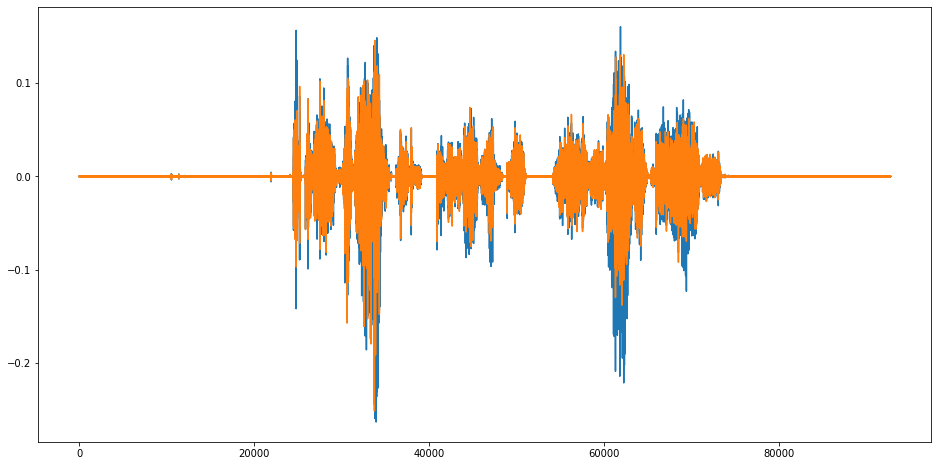

In [408]:
plt.figure(figsize=(16,8))
plt.plot(resfast.ravel())
plt.plot(res2fast.ravel())


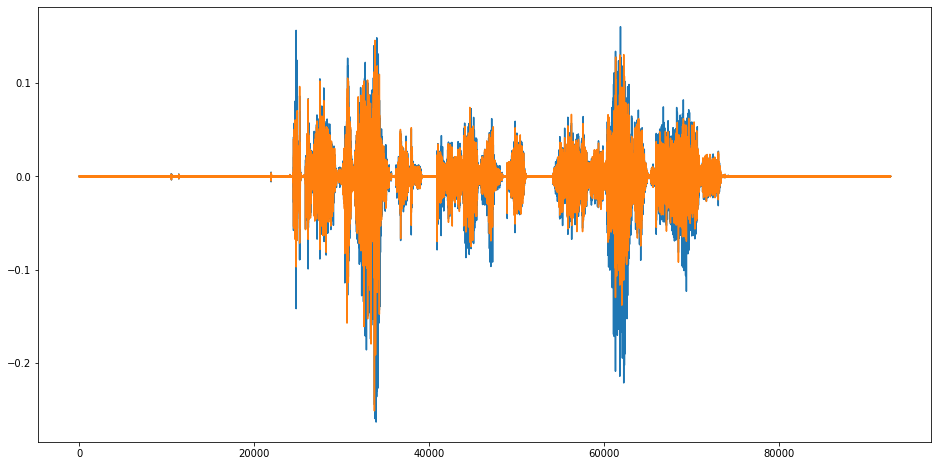

In [406]:
plt.figure(figsize=(16,8))
plt.plot(ress.ravel())
plt.plot(res2.ravel())


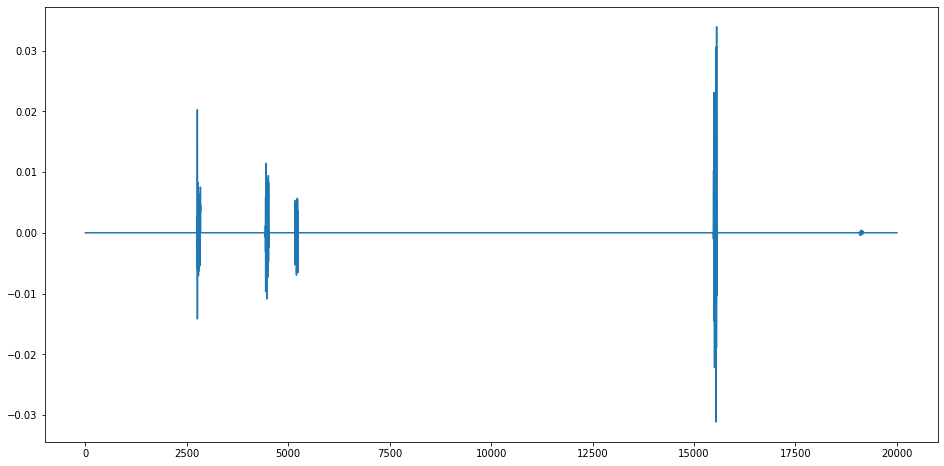

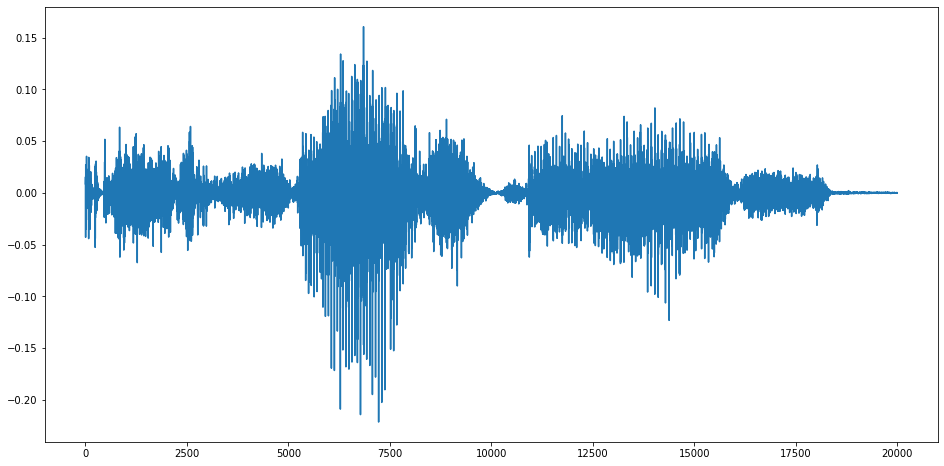

In [428]:
plt.figure(figsize=(16,8))
plt.plot(res2.ravel()[55000:75000] - res2fast.ravel()[55000:75000])
plt.figure(figsize=(16,8))
plt.plot(ress.ravel()[55000:75000])


In [423]:
ress.ravel()[np.where(np.abs(res2.ravel() - res2fast.ravel())>0.01)[0] ]

array([-0.01478141, -0.01821847,  0.00534897, -0.00288434, -0.00805902,
        0.01142079,  0.00869057, -0.00491565, -0.0617776 ,  0.0032882 ,
        0.03614751, -0.03669834,  0.00566328,  0.0162181 ,  0.00858021,
       -0.0084189 ,  0.01063561,  0.00405416,  0.02218318, -0.00047825,
        0.01273644,  0.00906606,  0.02201593,  0.01494627,  0.00231272,
        0.01963163, -0.0075155 , -0.01888253,  0.02605592,  0.01162972,
        0.04642476, -0.04462987, -0.01198011,  0.03715908,  0.00984371,
       -0.00148308, -0.04572504])

In [425]:
np.mean(np.abs(ress))


0.005603610475653669

In [ ]:
def compute_gain_mean(res, frame):
    gain_frame = np.nanmean(frame ** 2, axis=1) / np.nanmean(res ** 2, axis=1)
    gain = np.nanmean(gain_frame)
    return gain


def compute_gain_max(res, frame):
    gain_frame = np.nanmean(frame ** 2, axis=1) / np.nanmean(res ** 2, axis=1)
    gain_max = np.nanmax(gain_frame)
    return gain_max


def compute_gain_min(res, frame):
    gain_frame = np.nanmean(frame ** 2, axis=1) / np.nanmean(res ** 2, axis=1)
    gain_min= np.nanmin(gain_frame)
    return gain_min


def compute_gain_var(res, frame):
    gain_frame = np.nanmean(frame ** 2, axis=1) / np.nanmean(res ** 2, axis=1)
    gain_var = np.nanvar(gain_frame)
    return gain_var


def compute_res_mean(res):
    res_energy_frame = np.nanmean(res ** 2, axis=1)
    res_energy = np.nanmean(res_energy_frame)
    return res_energy


def compute_res_max(res):
    max_frame = np.nanmax(res, axis=1)
    max_res = np.nanmean(max_frame)
    return max_res


def compute_res_min(res):
    min_frame = np.nanmin(res, axis=1)
    min_res = np.nanmean(min_frame) 
    return min_res


def compute_res_var(res):
    var_frame = np.nanvar(res, axis=1)
    var_res = np.nanmean(var_frame)
    return var_res


In [ ]:
def compute_features_single(data, lpc_length):

    data_dict = {}
    
    data_dict['lpc_res_mean'] = None
    data_dict['lpc_res_max'] = None
    data_dict['lpc_res_min'] = None
    data_dict['lpc_res_var'] = None
    
    data_dict['lpc_gain_mean'] = None
    data_dict['lpc_gain_max'] = None
    data_dict['lpc_gain_min'] = None
    data_dict['lpc_gain_var'] = None
    
    data_dict['ltp_res_mean'] = None
    data_dict['ltp_res_max'] = None
    data_dict['ltp_res_min'] = None
    data_dict['ltp_res_var'] = None
    
    data_dict['ltp_gain_mean'] = None
    data_dict['ltp_gain_max'] = None
    data_dict['ltp_gain_min'] = None
    data_dict['ltp_gain_var'] = None

    res, _ , frames = compute_lpc(data, len_lpc=lpc_length)
    
    
    ltp_res, ltp_frames  = compute_ltp(res.ravel())

    lpc_res_mean = compute_res_mean(res)
    lpc_res_max = compute_res_max(res)
    lpc_res_min = compute_res_min(res)
    lpc_res_var = compute_res_var(res)
    
    lpc_gain_mean = compute_gain_mean(res, frames)
    lpc_gain_max = compute_gain_max(res, frames)
    lpc_gain_min = compute_gain_min(res, frames)
    lpc_gain_var = compute_gain_var(res, frames)
    
    
    ltp_res_mean = compute_res_mean(ltp_res)
    ltp_res_max = compute_res_max(ltp_res)
    ltp_res_min = compute_res_min(ltp_res)
    ltp_res_var = compute_res_var(ltp_res)
 
    ltp_gain_mean = compute_gain_mean(ltp_res, ltp_frames)
    ltp_gain_max = compute_gain_max(ltp_res, ltp_frames)
    ltp_gain_min = compute_gain_min(ltp_res, ltp_frames)
    ltp_gain_var = compute_gain_var(ltp_res, ltp_frames)


    # Store data
    data_dict['start_voice'] = 0
    data_dict['end_voice'] = len(data)
    
    data_dict['lpc_res_mean'] = lpc_res_mean
    data_dict['lpc_res_max'] = lpc_res_max
    data_dict['lpc_res_min'] = lpc_res_min
    data_dict['lpc_res_var'] = lpc_res_var
    
    data_dict['lpc_gain_mean'] = lpc_gain_mean
    data_dict['lpc_gain_max'] = lpc_gain_max
    data_dict['lpc_gain_min'] = lpc_gain_min
    data_dict['lpc_gain_var'] = lpc_gain_var

    data_dict['ltp_res_mean'] = ltp_res_mean
    data_dict['ltp_res_max'] = ltp_res_max
    data_dict['ltp_res_min'] = ltp_res_min
    data_dict['ltp_res_var'] = ltp_res_var
    
    data_dict['ltp_gain_mean'] = ltp_gain_mean
    data_dict['ltp_gain_max'] = ltp_gain_max
    data_dict['ltp_gain_min'] = ltp_gain_min
    data_dict['ltp_gain_var'] = ltp_gain_var
    
    return data_dict

In [ ]:
def compute_features_single_voiced(data, min_length_sec, lpc_length):


    segments = run_vad(data)
    # Check if at least one voiced segment is present
    voiced_segments = [d for d in segments if
                       d['is_speech'] is True and d['stop'] - d['start'] >= min_length_sec * samplerate]

    # Init data
    data_dict = {}
    
    data_dict['lpc_res_mean'] = None
    data_dict['lpc_res_max'] = None
    data_dict['lpc_res_min'] = None
    data_dict['lpc_res_var'] = None
    
    data_dict['lpc_gain_mean'] = None
    data_dict['lpc_gain_max'] = None
    data_dict['lpc_gain_min'] = None
    data_dict['lpc_gain_var'] = None
    
    data_dict['ltp_res_mean'] = None
    data_dict['ltp_res_max'] = None
    data_dict['ltp_res_min'] = None
    data_dict['ltp_res_var'] = None
    
    data_dict['ltp_gain_mean'] = None
    data_dict['ltp_gain_max'] = None
    data_dict['ltp_gain_min'] = None
    data_dict['ltp_gain_var'] = None

    
    if voiced_segments == []:
        return data_dict
    else:
        #  Segment
        voiced = data[voiced_segments[0]['start']: voiced_segments[0]['stop']]
        
        start = time.time()
        res, _, frames = compute_lpc(voiced, len_lpc=lpc_length)
        print("LPC execution time is " + str(time.time() - start))
        
        start = time.time()
        ltp_res, ltp_frames  = compute_ltp(res.ravel())
        print("LTP execution time is " + str(time.time() - start))


        lpc_res_mean = compute_res_mean(res)
        lpc_res_max = compute_res_max(res)
        lpc_res_min = compute_res_min(res)
        lpc_res_var = compute_res_var(res)

        lpc_gain_mean = compute_gain_mean(res, frames)
        lpc_gain_max = compute_gain_max(res, frames)
        lpc_gain_min = compute_gain_min(res, frames)
        lpc_gain_var = compute_gain_var(res, frames)

        ltp_res_mean = compute_res_mean(ltp_res)
        ltp_res_max = compute_res_max(ltp_res)
        ltp_res_min = compute_res_min(ltp_res)
        ltp_res_var = compute_res_var(ltp_res)

        ltp_gain_mean = compute_gain_mean(ltp_res, ltp_frames)
        ltp_gain_max = compute_gain_max(ltp_res, ltp_frames)
        ltp_gain_min = compute_gain_min(ltp_res, ltp_frames)
        ltp_gain_var = compute_gain_var(ltp_res, ltp_frames)

        # Store data
        data_dict['start_voice'] = voiced_segments[0]['start']
        data_dict['end_voice'] = voiced_segments[0]['stop']
        
        data_dict['lpc_res_mean'] = lpc_res_mean
        data_dict['lpc_res_max'] = lpc_res_max
        data_dict['lpc_res_min'] = lpc_res_min
        data_dict['lpc_res_var'] = lpc_res_var

        data_dict['lpc_gain_mean'] = lpc_gain_mean
        data_dict['lpc_gain_max'] = lpc_gain_max
        data_dict['lpc_gain_min'] = lpc_gain_min
        data_dict['lpc_gain_var'] = lpc_gain_var

        data_dict['ltp_res_mean'] = ltp_res_mean
        data_dict['ltp_res_max'] = ltp_res_max
        data_dict['ltp_res_min'] = ltp_res_min
        data_dict['ltp_res_var'] = ltp_res_var

        data_dict['ltp_gain_mean'] = ltp_gain_mean
        data_dict['ltp_gain_max'] = ltp_gain_max
        data_dict['ltp_gain_min'] = ltp_gain_min
        data_dict['ltp_gain_var'] = ltp_gain_var        
        
    return data_dict




In [ ]:
audio_folder = '/nas/home/cborrelli/bot_speech/notebook/audio/bonafide' 
audio_filename = 'LA_T_1011221.flac'
data, samplerate = sf.read(os.path.join(audio_folder, audio_filename))



In [ ]:
sample_data = [f for f in os.listdir(audio_folder) if f.endswith('.flac')]

In [ ]:
l = 2
for audio_filename in sample_data[:3]:
    data, samplerate = sf.read(os.path.join(audio_folder, audio_filename))
    compute_features_single(data, lpc_length=l)
    compute_features_single_voiced(data, lpc_length=l, min_length_sec = 1)

In [ ]:
for feat in zip(a,b):
    print(feat[0])
    print(a[feat[0]])
    print(b[feat[1]])
    

In [ ]:
audio_folder = '/nas/home/cborrelli/bot_speech/notebook/audio/bonafide' 
audio_filename = 'LA_T_1011221.flac'
data, samplerate = sf.read(os.path.join(audio_folder, audio_filename))

a = compute_features_single(data, lpc_length=10)